# EAW (two kappa model vs two temperature model)

In [215]:
import numpy as np
from prettytable import PrettyTable
import mpmath
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [216]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

## Models
- Comparison of different models of EAWs
- let $\theta_s = \theta_c$, $\theta_f=\theta_h$, $n_s=n_c$, $n_f=n_h$
- distributions
$$ f_f = f_h = \frac{n_f}{\sqrt{2\pi \theta_f^2}} \exp\left(-\frac{v^2}{\theta_f^2}\right)$$
$$ f_s = \frac{n_s}{\sqrt{2\pi \theta_s^2}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{v^2}{\kappa_s \theta_s^2} \right)^{-\kappa_s} $$
$$ f_c = \frac{n_s}{\sqrt{2\pi \theta_s^2}} \exp\left(-\frac{v^2}{\theta_s^2}\right)$$

In [217]:
def f_f(v):
    return n_f/np.sqrt(2*np.pi*v_f**2)*np.exp(-v**2/v_f**2)
def f_c(v):
    return n_s/np.sqrt(2*np.pi*v_s**2)*np.exp(-v**2/v_s**2)
def f_s(v):
    return n_s/np.sqrt(2*np.pi*v_s**2)*(1+v**2/kappa_s/v_s**2)**(-kappa_s)
def PrintParas():
    paras_table = PrettyTable(['-','n','kappa','wp','theta','lambda_D','T'])
    paras_table.add_row(['s',n_s,round(kappa_s,4),round(wp_s,4),round(v_s,4),round(l_s,4),round(T_s,4)])
    paras_table.add_row(['c',n_s,'-',round(wp_s,4),round(v_s,4),round(l_c,4),round(T_c,4)])
    paras_table.add_row(['f',n_f,'-',round(wp_f,4),round(v_f,4),round(l_f,4),round(T_f,4)])
    print(paras_table)

In [218]:
n=1
q = 1
m = 1

n_s = 0.5
n_f = n-n_s
v_s = 0.05
v_f = 1
kappa_s = 1.5/(1-v_s**2/v_f**2)
wp_s = np.sqrt( n_s * q**2 )
wp_f = np.sqrt( n_f * q**2 )
l_c = np.sqrt( v_s**2 / 2 / n_s / q**2 ) 
l_s = np.sqrt( kappa_s*v_s**2/(2*kappa_s-3) / n_s / q**2)
l_f = np.sqrt( v_f**2 / 2 / n_f / q**2 )
T_f = v_f**2/2
T_c = v_s**2/2
T_s = kappa_s*v_s**2/(2*kappa_s-3)
PrintParas()

+---+-----+--------+--------+-------+----------+--------+
| - |  n  | kappa  |   wp   | theta | lambda_D |   T    |
+---+-----+--------+--------+-------+----------+--------+
| s | 0.5 | 1.5038 | 0.7071 |  0.05 |   1.0    |  0.5   |
| c | 0.5 |   -    | 0.7071 |  0.05 |   0.05   | 0.0013 |
| f | 0.5 |   -    | 0.7071 |   1   |   1.0    |  0.5   |
+---+-----+--------+--------+-------+----------+--------+


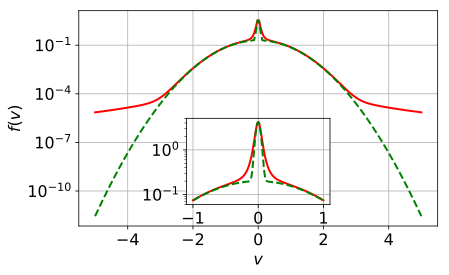

In [219]:
fig = plt.figure(figsize=(5,3))
v_le = np.linspace(-1,1,num=200)
v_he = np.linspace(-5,5,num=200)

# ax1 = plt.subplot(121)
ax1 = fig.add_axes([0.0,0.0,1.0,1.0])
ax1.plot(v_he,f_f(v_he)+f_s(v_he),color='red')
ax1.plot(v_he,f_f(v_he)+f_c(v_he),'--',color='green')
ax1.set_yscale('log')
ax1.set_ylabel('$f(v)$')
ax1.set_xlabel('$v$')
ax1.grid()

# ax2 = plt.subplot(122)
ax2 = fig.add_axes([0.3,0.1,0.4,0.4])
ax2.plot(v_le,f_f(v_le)+f_s(v_le),color='red')
ax2.plot(v_le,f_f(v_le)+f_c(v_le),'--',color='green')
ax2.set_yscale('log')
ax2.grid()

# plt.savefig('./figs/fig6.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [220]:
# two kappa PDR
def complex_hyp2f1(a,b,c,z):
    return np.complex128(mpmath.hyp2f1(a,b,c,z))
def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1)
    z = 0.5*(1+1j*zeta/np.sqrt(kappa))
#     hyp2f1 = np.vectorize(complex_hyp2f1)
#     hyp = hyp2f1(1,2*kappa+2,kappa+2,z)
    hyp = np.complex128(mpmath.hyp2f1(1,2*kappa+2,kappa+2,z))
    return fac*hyp
vdispersion_function = np.vectorize(dispersion_function)
def PDR_2K(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    r = 1 + 2*wp_s**2 / k**2 / v_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 2*wp_f**2 / k**2 / v_f**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
    return [r.real,r.imag]

def PDR_2T(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    r = 1 + 2*wp_s**2 / k**2 / v_s**2 * ( 1 + zeta_s*plasmapy.dispersion.plasma_dispersion_func(zeta_s) ) + 2*wp_f**2 / k**2 / v_f**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
    return [r.real,r.imag]

In [221]:
wr_guess = 0.01
wi_guess = -0.04
klf_list = np.linspace(0.1,8.0,num=800)
k_list = klf_list/l_f

s0=op.root(lambda w:PDR_2K(w,k_list[0]),[wr_guess,wi_guess],method='hybr')
s1=op.root(lambda w:PDR_2T(w,k_list[0]),[wr_guess,wi_guess],method='hybr')
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wr_K_guess_int = s0.x[0]
wi_K_guess_int = s0.x[1]
wr_T_guess_int = s1.x[0]
wi_T_guess_int = s1.x[1]

k =  0.1
True [ 0.0516991  -0.02931156]
True [ 0.02050098 -0.01569166]


In [222]:
wr_K_guess = s0.x[0]
wi_K_guess = s0.x[1]
wr_T_guess = s1.x[0]
wi_T_guess = s1.x[1]

wr_K_list = np.array([])
wi_K_list = np.array([])
wr_T_list = np.array([])
wi_T_list = np.array([])

for k_each in tqdm(k_list,position=0,leave=True):
    s_k = op.root(lambda w:PDR_2K(w,k_each),[wr_K_guess,wi_K_guess])
    if s_k.success==True:
        wr_K_guess = round(s_k.x[0],10)
        wi_K_guess = round(s_k.x[1],10)
        wr_K_list = np.append(wr_K_list,s_k.x[0])
        wi_K_list = np.append(wi_K_list,s_k.x[1])
    else:
        wr_K_list = np.append(wr_K_list,np.nan)
        wi_K_list = np.append(wi_K_list,np.nan)
        
    s_t = op.root(lambda w:PDR_2T(w,k_each),[wr_T_guess,wi_T_guess],method='hybr')
    if s_t.success==True:
        wr_T_guess = round(s_t.x[0],6)
        wi_T_guess = round(s_t.x[1],6)
        wr_T_list = np.append(wr_T_list,s_t.x[0])
        wi_T_list = np.append(wi_T_list,s_t.x[1])
    else:
        wr_T_list = np.append(wr_T_list,np.nan)
        wi_T_list = np.append(wi_T_list,np.nan)

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:23<00:00, 34.76it/s]


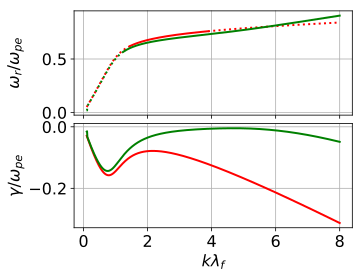

In [224]:
fig = plt.figure(figsize=(5,4))
x_ticks = np.linspace(0.0,8.0,num=5)

ax1 = plt.subplot(211)
# ax1.set_xlabel('$k \lambda_s$')
plt.xticks(x_ticks,())

ax2 = plt.subplot(212)
ax2.set_xlabel('$k \lambda_f$')
plt.xticks(x_ticks)

b_K = wi_K_list/abs(wr_K_list/2/np.pi)
b_T = wi_T_list/abs(wr_T_list/2/np.pi)

ax1.set_ylabel(r'$\omega_r/\omega_{pe}$',labelpad=18)
ax2.set_ylabel(r'$\gamma/\omega_{pe}$')
ax1.grid()
ax2.grid()

strongdamping_1 = klf_list[b_K<=-1] <= klf_list[b_K>-1][0]
strongdamping_2 = klf_list[b_K<=-1] >= klf_list[b_K>-1][0]
# strongdamping_3 = klf_list[b_T<=-1] <= klf_list[b_T>-1][0]
# strongdamping_4 = klf_list[b_T<=-1] >= klf_list[b_T>-1][0]

ax1.plot(klf_list[b_K<-1][strongdamping_1],wr_K_list[b_K<-1][strongdamping_1],':',color='red')
ax1.plot(klf_list[b_K<-1][strongdamping_2],wr_K_list[b_K<-1][strongdamping_2],':',color='red')
# ax1.plot(klf_list[b_K<=-1],wr_K_list[b_K<=-1],':',color='red')
ax1.plot(klf_list[b_K>-1],wr_K_list[b_K>-1],'-',color='red')

# ax1.plot(klf_list[b_T<-1][strongdamping_3],wr_T_list[b_T<-1][strongdamping_3],':',color='green')
# ax1.plot(klf_list[b_T<-1][strongdamping_4],wr_T_list[b_T<-1][strongdamping_4],':',color='green')
ax1.plot(klf_list[b_T<=-1],wr_T_list[b_T<=-1],':',color='green')
ax1.plot(klf_list[b_T>-1],wr_T_list[b_T>-1],'-',color='green')

ax2.plot(klf_list,wi_K_list,color='red')
ax2.plot(klf_list,wi_T_list,color='green')

plt.subplots_adjust(hspace = 0.08,wspace=0.0)
# plt.savefig('./figs/revised/fig7.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

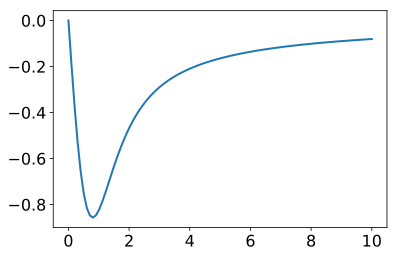

In [214]:
zz = np.linspace(0,10,num=100)
plt.plot(zz,vdispersion_function(zz,2.5).real)
# plt.yscale('log')
plt.show()

In [207]:
a = mpmath.linspace(1,3,5)
y = mpmath.iv.cos(a)
print(y)

TypeError: cannot unpack non-iterable NoneType object